In [45]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

In [29]:
# Load dataset
data = pd.read_csv('/content/email_spam.csv')

In [46]:
data.head()

,title,text,type
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...",1
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",0
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",0
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",0
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...",1


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   84 non-null     object
 1   text    84 non-null     object
 2   type    84 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ KB


In [48]:
data.describe()

,type
count,84.000000
mean,0.309524
std,0.465074
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [50]:
print(data.columns)

Index(['title', 'text', 'type'], dtype='object')


In [52]:
print(data['type'].unique())

[1 0]


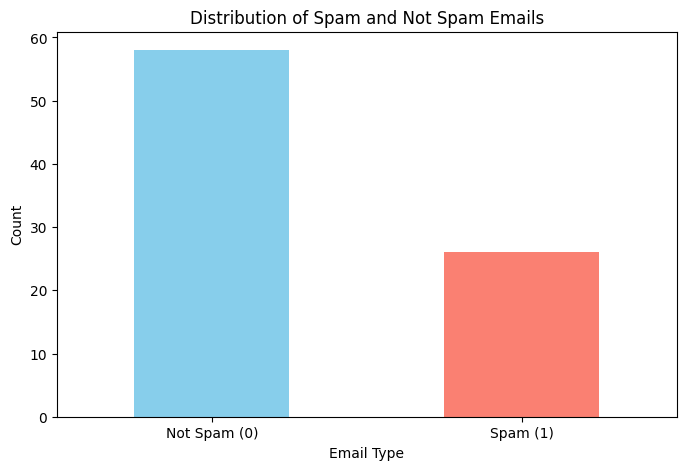

In [54]:
# Visualization of the distribution of spam and not spam emails
plt.figure(figsize=(8, 5))
data['type'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Spam and Not Spam Emails')
plt.xlabel('Email Type')
plt.xticks(ticks=[0, 1], labels=['Not Spam (0)', 'Spam (1)'], rotation=0)
plt.ylabel('Count')
plt.show()

Number of spam emails: 26


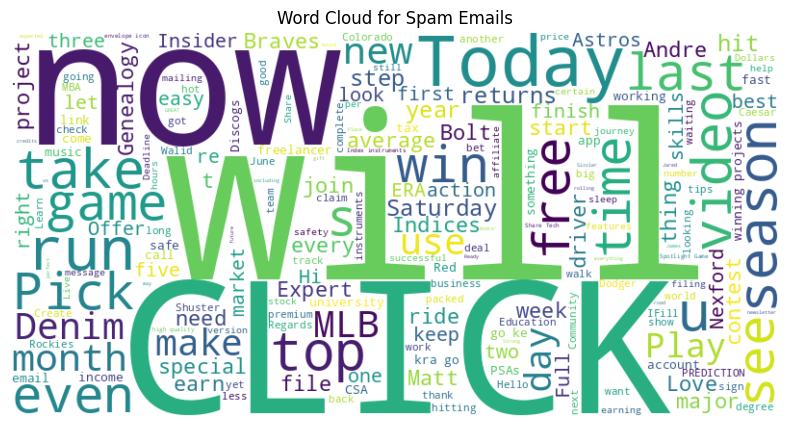

In [53]:
# Filter spam emails (1 for spam)
spam_emails = data[data['type'] == 1]['text']
print(f'Number of spam emails: {len(spam_emails)}')

if len(spam_emails) > 0:
    spam_text = ' '.join(spam_emails)

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Spam Emails')
    plt.show()
else:
    print("No spam emails found.")

Number of not spam emails: 58


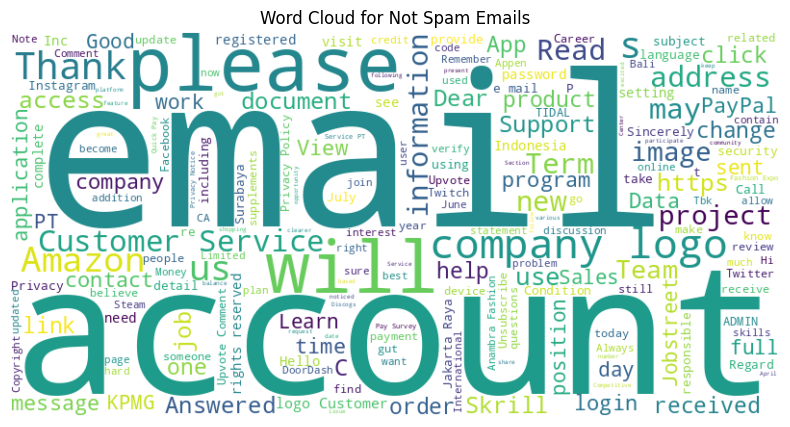

In [55]:
# Filter not spam emails (0 for not spam)
not_spam_emails = data[data['type'] == 0]['text']
print(f'Number of not spam emails: {len(not_spam_emails)}')

# Create a word cloud for not spam emails
if len(not_spam_emails) > 0:
    not_spam_text = ' '.join(not_spam_emails)

    # Generate the word cloud
    wordcloud_not_spam = WordCloud(width=800, height=400, background_color='white').generate(not_spam_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_not_spam, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Not Spam Emails')
    plt.show()
else:
    print("No not spam emails found.")

In [30]:
# Encode labels
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])  # Spam = 1, Not Spam = 0


In [31]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['type'], test_size=0.2, random_state=42)


In [32]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [33]:
# Padding sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [34]:
# Model definition
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            41024     
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 48, 64)            33024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 64)                0

In [35]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32,
                    validation_split=0.1, callbacks=[early_stopping])


Epoch 1/10
2/2 [==============================] - 3s 690ms/step - loss: 0.6915 - accuracy: 0.5333 - val_loss: 0.7012 - val_accuracy: 0.4286
Epoch 2/10
2/2 [==============================] - 0s 173ms/step - loss: 0.6707 - accuracy: 0.7667 - val_loss: 0.7107 - val_accuracy: 0.4286
Epoch 3/10
2/2 [==============================] - 0s 143ms/step - loss: 0.6504 - accuracy: 0.7333 - val_loss: 0.7251 - val_accuracy: 0.4286
Epoch 4/10
2/2 [==============================] - 0s 174ms/step - loss: 0.6229 - accuracy: 0.7333 - val_loss: 0.7496 - val_accuracy: 0.4286


In [36]:
# Model evaluation
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))


1/1 [==============================] - 0s 290ms/step
Confusion Matrix:
[[11  0]
 [ 6  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# Save the model
model.save('email_spam_detector.h5')

# To load the model later
from tensorflow.keras.models import load_model
loaded_model = load_model('email_spam_detector.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


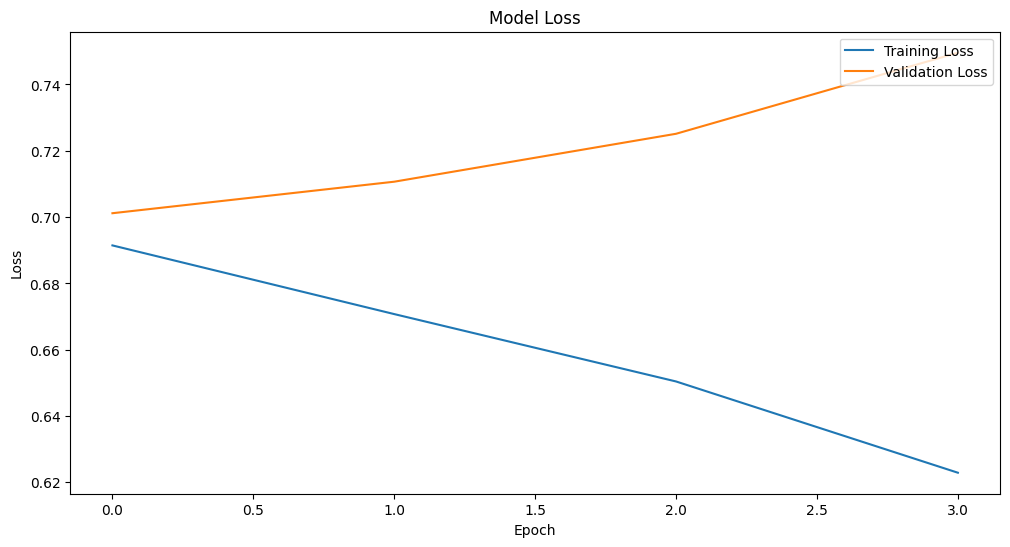

In [39]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

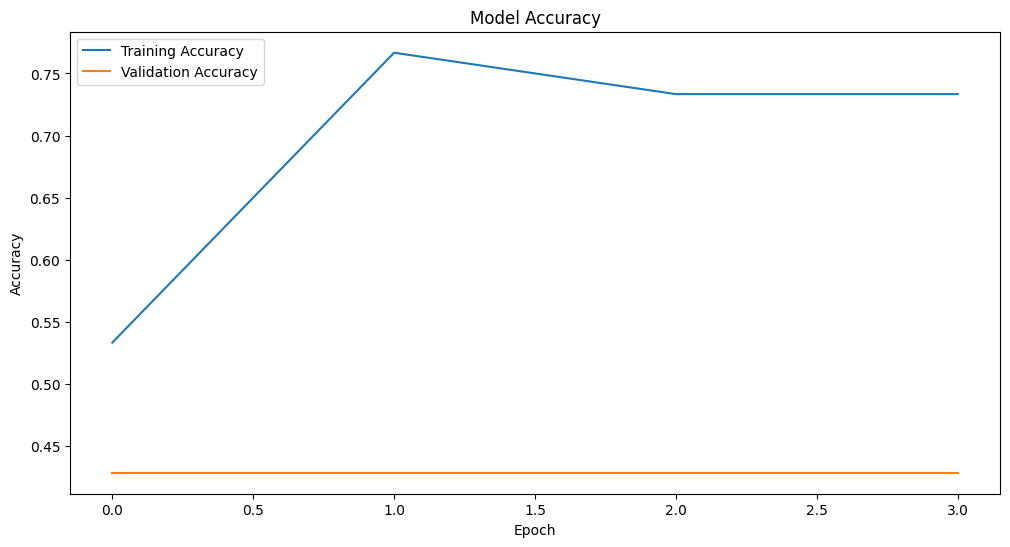

In [40]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix




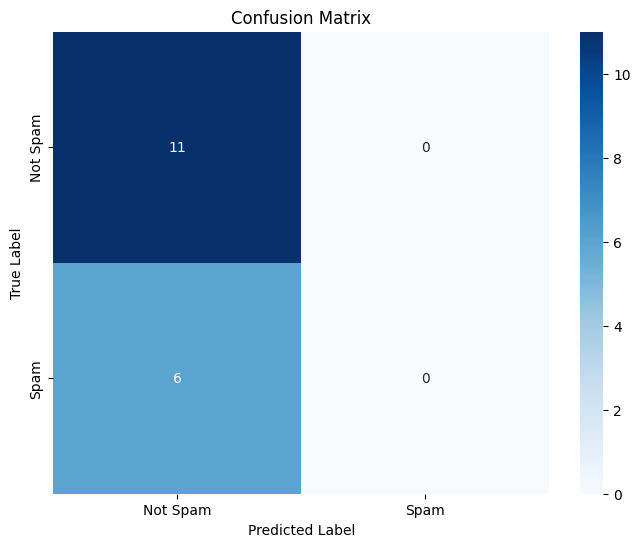

In [42]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spam', 'Spam'],
            yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


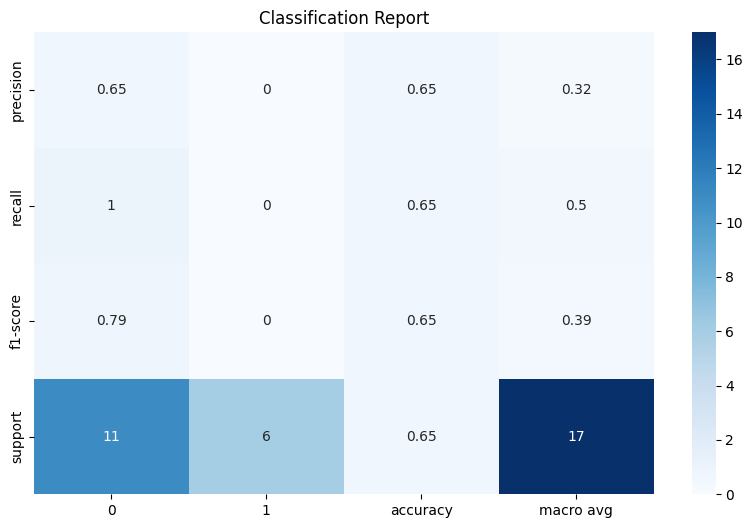

In [43]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()


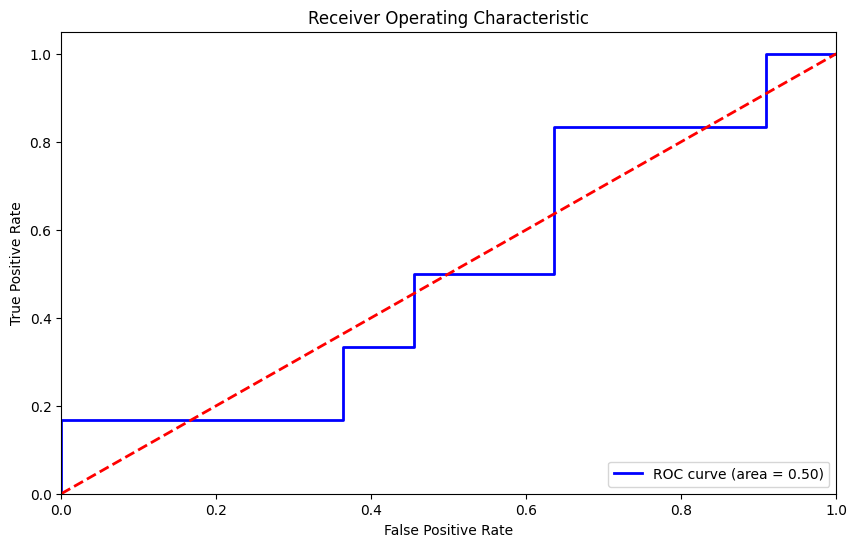

In [44]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
